# Differential expression analysis along erythroid trajectory

[Berge et al., 2020 tradeSeq](https://www.nature.com/articles/s41467-020-14766-3)  


For tradeSeq we need weights to asign cells to trajectoris. That is not yet possible with [RNA-velocities or CellRank](https://github.com/statOmics/tradeSeq/issues/164). With monocle3 it is very [difficult](https://github.com/satijalab/seurat/issues/1658) to use the results from Scanorama. The best way forward seems to be [slingshot](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-018-4772-0) which has a direct interaface to tradeSeq and uses the existing results e.g. cluster, UMAP, etc. 

In [124]:
library_load <- suppressMessages(
    
    list(
        
        # Seurat
        library(Seurat), 
        
        # TradeSeq
        library(tradeSeq), 
        
        # Slingshot
        library(slingshot), 
        
        # SingleCellExperiment
        library(SingleCellExperiment), 
        
        # Plotting
        library(ggplot2), 
        
        # Data handling
        library(tidyverse)
        
        
        
    )
)

In [125]:
random_seed <- 42
set.seed(random_seed)

In [126]:
options(warn=-1)

In [127]:
# Set working directory to project root
setwd("/research/peer/fdeckert/FD20200109SPLENO")

In [128]:
# Source files
source("plotting_global.R")
source("bin/SeuratQC.R")

In [129]:
# Plotting Theme
ggplot2::theme_set(theme_global_set())

# Import Seurat object and latent time

In [130]:
so <- readRDS("data/object/int.rds")

In [131]:
# Import latent time from scvelo analysis 
latent_time <- read.csv("result/scvelo/latent_time_grp.csv", row.names=1)
so <- AddMetaData(so, latent_time)

In [132]:
leiden_ery <- c("MPP (1)", "Ery (1)", "Ery (2)", "Ery (3)", "Ery (4)", "Ery (5)", "Ery (6)")
label_fine_haemosphere_ery <- c("preCFUE", "CFUE", "pbEry", "poEry", "Retic")

# so <- subset(so, subset = leiden_annotation %in% leiden_ery & label_fine_haemosphere %in% label_fine_haemosphere_ery)
so <- subset(so, subset = leiden_annotation %in% leiden_ery)

In [133]:
table(so$label_fine_haemosphere)


   Baso     cDC    CFUE     CLP     CMP      Eo     GMP     LSK    Mast     Meg 
     38       2    2438       7     102       2       6      19       1      49 
    MEP      Mo     MPP   pbEry     pDC   poEry preCFUE   Retic   STHSC  T-cell 
    385      11      45    6956       7     285    2116       6     185       2 

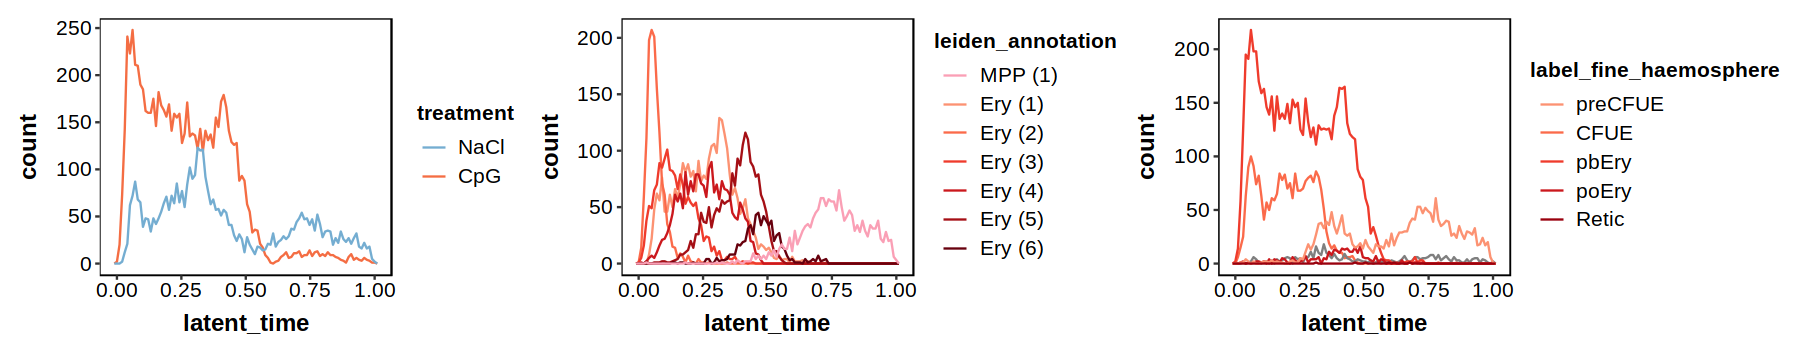

In [134]:
options(repr.plot.width=15, repr.plot.height=3)

dp_1 <- ggplot(so@meta.data, aes(x=latent_time, color=treatment)) + 
    geom_freqpoly(bins=100) + 
    scale_color_manual(values=color$treatment)

dp_2 <- ggplot(so@meta.data, aes(x=latent_time, color=leiden_annotation)) + 
    geom_freqpoly(bins=100) + 
    scale_color_manual(values=color$leiden_annotation[names(color$leiden_annotation) %in% leiden_ery])

dp_3 <- ggplot(so@meta.data, aes(x=latent_time, color=label_fine_haemosphere)) + 
    geom_freqpoly(bins=100) + 
    scale_color_manual(values=color$label_fine_haemosphere[names(color$label_fine_haemosphere) %in% label_fine_haemosphere_ery])

dp_1 + dp_2 + dp_3 

# Slingshot

General [Tutorial](https://bioconductor.org/packages/devel/bioc/vignettes/slingshot/inst/doc/vignette.html) and for [perturbation](https://kstreet13.github.io/bioc2020trajectories/articles/workshopTrajectories.html#:~:text=To%20test%20differential%20expression%20between,or%20lower%20than%201%2F2.) along the trajectory

In [135]:
sce <- as.SingleCellExperiment(so, assay="RNA")

In [136]:
# Run slinshot 
sce <- slingshot(sce, clusterLabels='leiden_annotation', reducedDim='X_UMAP', start.clus="MPP (1)")
write.csv(data.frame(pseudotime=sce$slingPseudotime_1, cell_id=colnames(sce)), "result/slingshot/pseudotime.csv")

In [137]:
so$pseudotime <- sce$slingPseudotime_1

In [138]:
rownames(so)[grep("Hba-|Hbb-|Hbq1b|Hbq1a", rownames(so))]

[1] "Hbb-bt" "Hbb-bs" "Hba-a1" "Hbq1b"  "Hba-a2" "Hbb-y"  "Hba-x"  "Hbq1a"

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



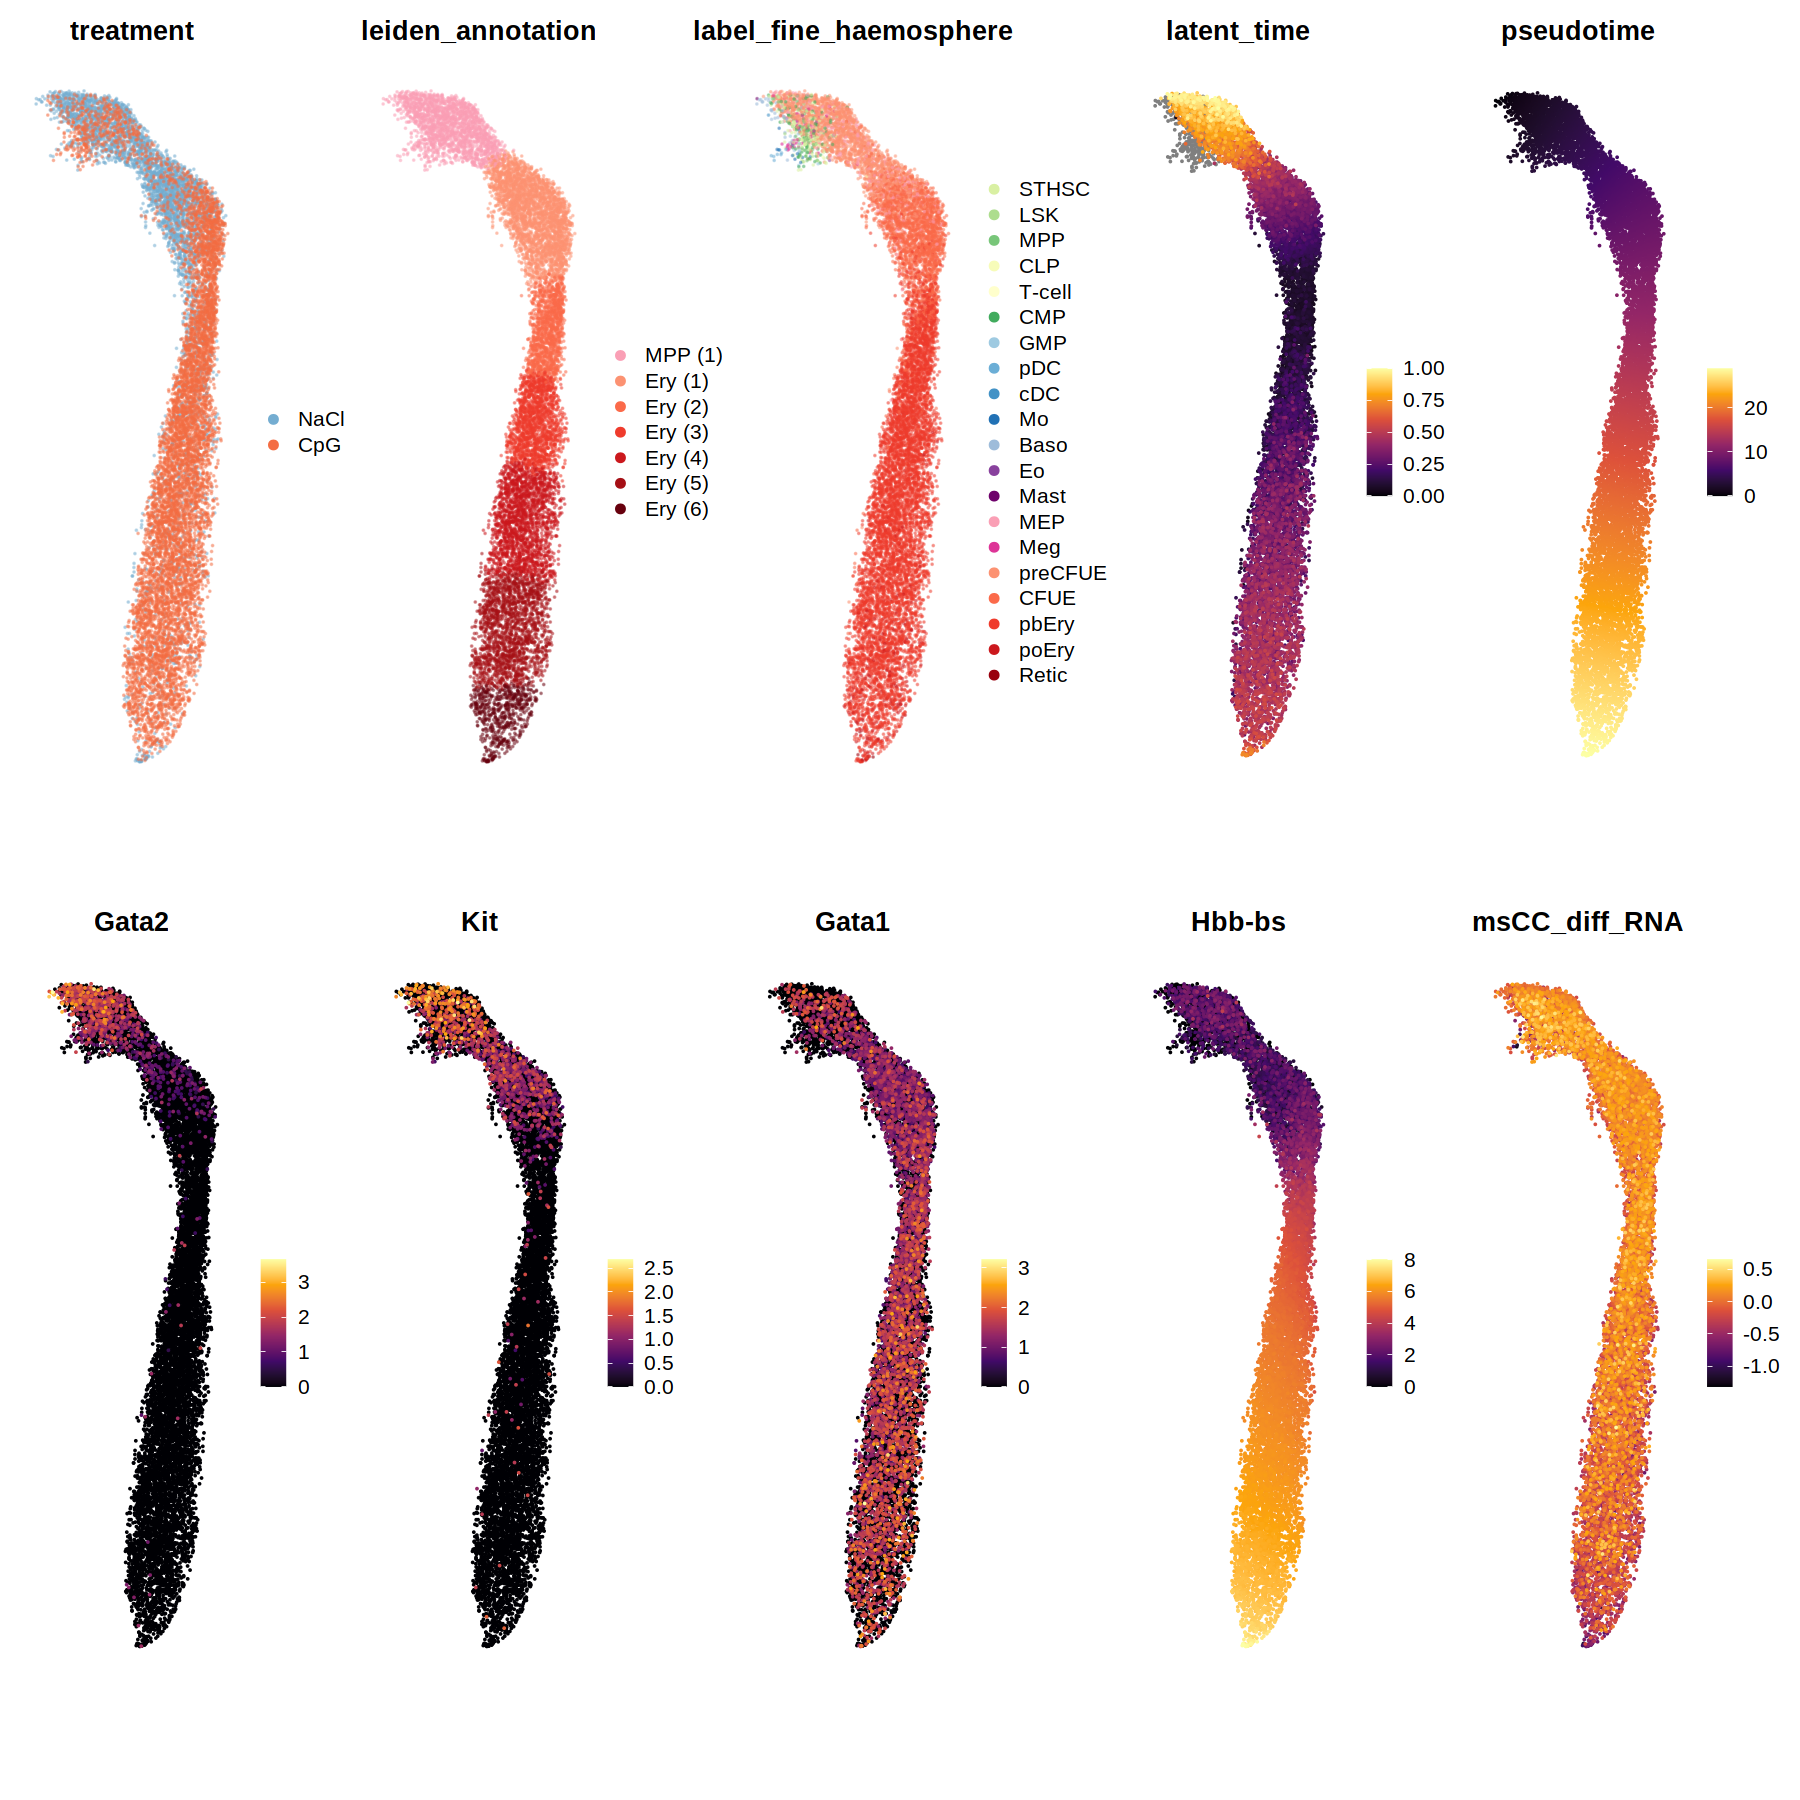

In [139]:
options(repr.plot.width=15, repr.plot.height=15)

dplot_1 <- dplot(so, group_by="treatment", reduction="X_umap") + scale_color_manual(values=color$treatment) + theme(aspect.ratio=3.5)
dplot_2 <- dplot(so, group_by="leiden_annotation", reduction="X_umap") + scale_color_manual(values=color$leiden_annotation[names(color$leiden_annotation) %in% leiden_ery]) + theme(aspect.ratio=3.5)
dplot_3 <- dplot(so, group_by="label_fine_haemosphere", reduction="X_umap") + scale_color_manual(values=color$label_fine_haemosphere[names(color$label_fine_haemosphere) %in% so$label_fine_haemosphere]) + theme(aspect.ratio=3.5)
fplot_1 <- fplot(so, feature="latent_time", reduction="X_umap") + scale_colour_viridis_c(option="inferno") + theme(aspect.ratio=3.5)
fplot_2 <- fplot(so, feature="pseudotime", reduction="X_umap") + scale_colour_viridis_c(option="inferno") + theme(aspect.ratio=3.5)
fplot_3 <- fplot(so, feature="Gata2", reduction="X_umap") + scale_colour_viridis_c(option="inferno") + theme(aspect.ratio=3.5)
fplot_4 <- fplot(so, feature="Kit", reduction="X_umap") + scale_colour_viridis_c(option="inferno") + theme(aspect.ratio=3.5)
fplot_5 <- fplot(so, feature="Gata1", reduction="X_umap") + scale_colour_viridis_c(option="inferno") + theme(aspect.ratio=3.5)
fplot_6 <- fplot(so, feature="Hbb-bs", reduction="X_umap") + scale_colour_viridis_c(option="inferno") + theme(aspect.ratio=3.5)
fplot_7 <- fplot(so, feature="msCC_diff_RNA", reduction="X_umap") + scale_colour_viridis_c(option="inferno") + theme(aspect.ratio=3.5)

dplot_1 + dplot_2 + dplot_3 + fplot_1 + fplot_2 + fplot_3 + fplot_4 + fplot_5 + fplot_6 + fplot_7 + plot_layout(ncol=5, nrow=2)

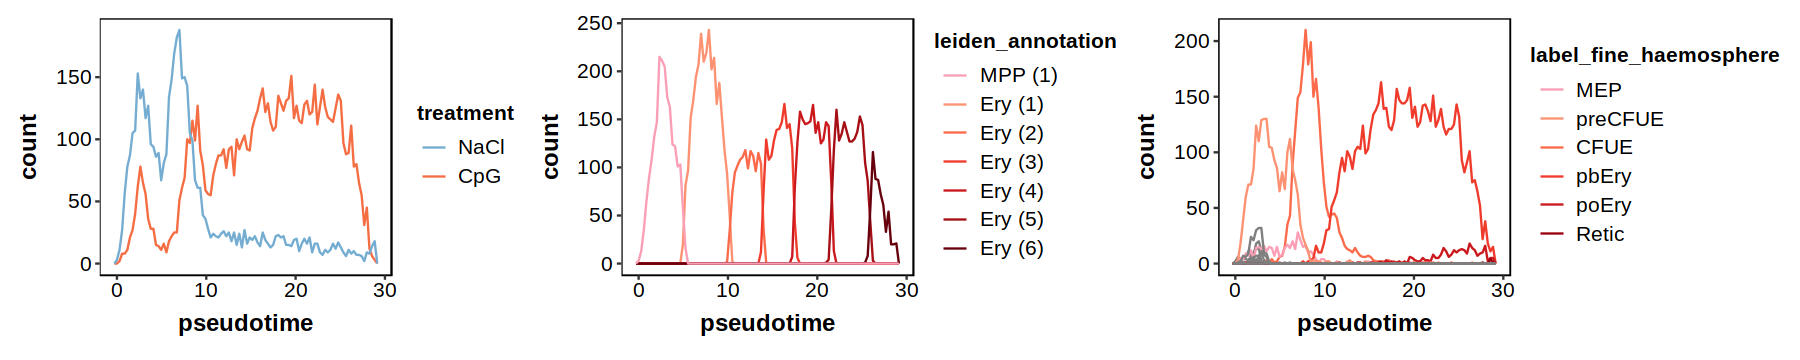

In [45]:
options(repr.plot.width=15, repr.plot.height=3)

dp_1 <- ggplot(so@meta.data, aes(x=pseudotime, color=treatment)) + 
    geom_freqpoly(bins=100) + 
    scale_color_manual(values=color$treatment)

dp_2 <- ggplot(so@meta.data, aes(x=pseudotime, color=leiden_annotation)) + 
    geom_freqpoly(bins=100) + 
    scale_color_manual(values=color$leiden_annotation[names(color$leiden_annotation) %in% leiden_ery])

dp_3 <- ggplot(so@meta.data, aes(x=pseudotime, color=label_fine_haemosphere)) + 
    geom_freqpoly(bins=100) + 
    scale_color_manual(values=color$label_fine_haemosphere[names(color$label_fine_haemosphere) %in% label_fine_haemosphere_ery])

dp_1 + dp_2 + dp_3 

# tradeSeq

Overview [tutorial](https://statomics.github.io/tradeSeq/articles/tradeSeq.html) and to compare [treatment](https://kstreet13.github.io/bioc2020trajectories/articles/workshopTrajectories.html#:~:text=To%20test%20differential%20expression%20between,or%20lower%20than%201%2F2.)

In [189]:
sce <- sce[apply(assay(sce)>0, 1, sum) > 0]

### Condition on treatment 

In [193]:
evealuate_k <- evaluateK(
    
    counts=as.matrix(assays(sce)$counts),
    pseudotime=slingPseudotime(sce, na=FALSE),
    cellWeights=slingCurveWeights(sce),
    conditions=factor(sce$treatment),
    nGenes=300,
    k=3:10

)

saveRDS(evealuate_k_condition, "result/tradeseq/evealuate_k.rds")

In [173]:
# sce <- fitGAM(sce, conditions=factor(sce$treatment), nknots=7)
# saveRDS(sce, "result/tradeseq/sce_condition.rds")

In [ ]:
# rowData(sce)$assocRes <- associationTest(sce, lineages=TRUE, l2fc=log2(2))

In [ ]:
# association_result <- rowData(sce)$assocRes

# nacl_genes <-  rownames(association_result)[which(p.adjust(association_result$waldStat_lineage1_conditionNaCl, "fdr") <= 0.05)]
# cpg_genes <-  rownames(association_result)[which(p.adjust(association_result$pvalue_lineage1_conditionCpG, "fdr") <= 0.05)]

# length(nacl_genes)
# length(cpg_genes)

In [ ]:
# UpSetR::upset(UpSetR::fromList(list(mock = nacl_genes, tgfb = cpg_genes)))

In [ ]:
# library(pheatmap)
# yhatSmooth <- predictSmooth(sce, gene = nacl_genes, nPoints = 50, tidy = FALSE)
# heatSmooth <- pheatmap(t(scale(t(yhatSmooth[, 1:50]))),
#                        cluster_cols = FALSE,
#                        show_rownames = FALSE, 
#                        show_colnames = FALSE)

In [ ]:
# library(pheatmap)
# yhatSmooth <- predictSmooth(sce, gene = cpg_genes, nPoints = 50, tidy = FALSE)
# heatSmooth <- pheatmap(t(scale(t(yhatSmooth[, 1:50]))),
#                        cluster_cols = FALSE,
#                        show_rownames = FALSE, 
#                        show_colnames = FALSE)

In [ ]:
# plotSmoothers(sce, assays(sce)$counts, gene="Gata1", alpha=1, border=TRUE) + ggtitle("Gata1")

In [ ]:
# condRes <- conditionTest(sce, l2fc = log2(2))
# condRes$padj <- p.adjust(condRes$pvalue, "fdr")

In [ ]:
# sum(condRes$padj <= 0.05, na.rm = TRUE)

In [ ]:
# conditionGenes <- rownames(condRes)[condRes$padj <= 0.05]
# conditionGenes <- conditionGenes[!is.na(conditionGenes)]

In [ ]:
# # plot genes
# oo <- order(condRes$waldStat, decreasing = TRUE)

# # most significant gene
# plotSmoothers(sce, assays(sce)$counts,
#               gene = rownames(assays(sce)$counts)[oo[1]],
#               alpha = 1, border = TRUE)

In [ ]:
# # least significant gene
# plotSmoothers(sce, assays(sce)$counts,
#               gene = rownames(assays(sce)$counts)[oo[nrow(sce)]],
#               alpha = 1, border = TRUE)

In [ ]:
# library("gridExtra")

# ### based on mean smoother
# yhatSmooth <- predictSmooth(sce, gene = conditionGenes, nPoints = 50, tidy = FALSE)
# yhatSmoothScaled <- t(scale(t(yhatSmooth)))
# heatSmooth_TGF <- pheatmap(yhatSmoothScaled[, 51:100],
#   cluster_cols = FALSE,
#   show_rownames = FALSE, show_colnames = FALSE, main = "TGF-Beta", legend = FALSE,
#   silent = TRUE
# )

# matchingHeatmap_mock <- pheatmap(yhatSmoothScaled[heatSmooth_TGF$tree_row$order, 1:50],
#   cluster_cols = FALSE, cluster_rows = FALSE,
#   show_rownames = TRUE, show_colnames = FALSE, main = "Mock",
#   legend = FALSE, silent = TRUE
# )

# grid.arrange(heatSmooth_TGF[[4]], matchingHeatmap_mock[[4]], ncol = 2)